In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import intersect1d, setdiff1d, quantile, unique, asarray, zeros
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
from copy import deepcopy


from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson
import scipy.sparse as sp
from scipy.io import mmread
from scipy.stats import pearsonr

from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import seaborn as sns
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available


import importlib

import sys
import umap
from fuzzywuzzy import process



/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import seaborn as sns
import pandas as pd
import importlib

import numpy as np
from numpy import intersect1d, setdiff1d, quantile, unique, asarray, zeros
from matplotlib import pyplot
import matplotlib.pyplot as plt

import sys
import umap
from fuzzywuzzy import process


In [4]:
# Add the src directory to the Python path
sys.path.append(os.path.abspath('/home/nandivada.s/genoTopheno/src'))

# Import the sciPENN_API module
import sciPENN.sciPENN_API
import sciPENN.Preprocessing

# Reload the module to ensure the latest changes are reflected
# importlib.reload(SCIPENN.sciPENN_API)

from sciPENN.sciPENN_API import sciPENN_API
from sciPENN.Preprocessing import preprocess


In [5]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [6]:
from sciPENN.Utils import build_dir
from sciPENN.Preprocessing import preprocess
from sciPENN.Data_Infrastructure.DataLoader_Constructor import build_dataloaders
from sciPENN.Network.Model import sciPENN_Model
from sciPENN.Network.Losses import cross_entropy, mse_quantile, no_loss

In [6]:
""" PBMC Read in Raw Data"""
adata_gene = sc.read("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/pbmc_gene.h5ad")
adata_protein = sc.read("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/pbmc_protein.h5ad")

In [7]:
adata_AML_gene = sc.read_10x_mtx('/home/nandivada.s/R/x86_64-pc-linux-gnu-library/filtered_matrices_mex/hg19')
adata_AML_gene.to_df()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2-1,AL590523.1,CT476828.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
AAACGCACTGGTGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAGAATGGTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAGATCCCGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATACTGGTGTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATCAACACCTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTATTCC-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCGAACTTCCAT-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTAGGTCT-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTCTACTCGCATA-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
adata_GSM5319_RNA = sc.read_csv("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/AML_datasets/GSM6805319_CITE1_RNA_counts.csv.gz").T
adata_GSM5320_ADT = sc.read_csv("/home/nandivada.s/R/x86_64-pc-linux-gnu-library/AML_datasets/GSM6805320_CITE1_ADT_counts.csv.gz").T

In [8]:
adata_GSM5319_RNA.obs_names = adata_GSM5319_RNA.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)
adata_GSM5319_RNA.to_df()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACCTGAGCAGCGTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGGTCTTGCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGGTTCGCTAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGTCGACAGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGAGGCATTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCACAAGTTCTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCAGTTTGGGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTCATCCAATGGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
adata_GSM5320_ADT.obs_names = adata_GSM5320_ADT.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)
adata_GSM5320_ADT.to_df()

,CD86.1,CD274.1,TNFRSF14.1,PVR.1,NECTIN2.1,CD47.1,CD48.1,CD40.1,CD40LG.1,CD52.1,...,FCER2.1,.10,SIGLEC7.1,ADGRG1.1,HLA-E.1,CD82.1,CD101.1,C5AR1.1,GGT1.2,SNRNP200.1
AAACCTGAGCAGCGTA-1,2.0,5.0,8.0,4.0,8.0,6.0,15.0,0.0,4.0,0.0,...,10.0,6.0,4.0,0.0,7.0,35.0,9.0,11.0,31.0,1.0
AAACCTGGTCTTGCGG-1,0.0,6.0,5.0,4.0,11.0,7.0,11.0,0.0,3.0,4.0,...,4.0,10.0,3.0,1.0,8.0,25.0,2.0,5.0,34.0,2.0
AAACCTGGTTCGCTAA-1,3.0,2.0,4.0,4.0,13.0,12.0,14.0,0.0,3.0,3.0,...,11.0,14.0,3.0,2.0,13.0,41.0,7.0,8.0,47.0,2.0
AAACCTGTCGACAGCC-1,1.0,4.0,6.0,2.0,2.0,3.0,5.0,1.0,3.0,3.0,...,6.0,14.0,0.0,1.0,6.0,31.0,9.0,7.0,34.0,1.0
AAACGGGAGGCATTGG-1,0.0,5.0,9.0,5.0,8.0,9.0,17.0,3.0,7.0,4.0,...,8.0,9.0,3.0,0.0,3.0,34.0,8.0,5.0,48.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,2.0,3.0,8.0,4.0,16.0,10.0,26.0,0.0,6.0,5.0,...,16.0,14.0,5.0,2.0,17.0,57.0,19.0,15.0,61.0,6.0
TTTGTCACAAGTTCTG-1,2.0,14.0,12.0,8.0,25.0,11.0,20.0,1.0,8.0,7.0,...,17.0,23.0,3.0,0.0,13.0,51.0,17.0,11.0,62.0,6.0
TTTGTCAGTTTGGGCC-1,2.0,2.0,3.0,1.0,2.0,6.0,5.0,0.0,2.0,3.0,...,4.0,7.0,2.0,0.0,4.0,12.0,5.0,0.0,24.0,1.0
TTTGTCATCCAATGGT-1,0.0,1.0,6.0,3.0,13.0,2.0,11.0,0.0,3.0,1.0,...,6.0,7.0,1.0,0.0,11.0,35.0,7.0,8.0,35.0,6.0


In [10]:
adata_gene_test = adata_GSM5319_RNA

In [ ]:
# Define the required parameters
gene_trainsets =  [adata_gene] # Your gene training datasets
protein_trainsets = [adata_protein]  # Your protein training datasets
gene_test = [adata_gene_test]  # Optional gene test datasets
gene_list = []  # Your list of genes
select_hvg = True
train_batchkeys = ['donor']
test_batchkey = 'donor'
type_key = 'celltype.l2'
cell_normalize = True
log_normalize = True
gene_normalize = True
min_cells = 3
min_genes = 20
batch_size = 128
val_split = 0.1
use_gpu = True

# Create an instance of the sciPENN_API class
sciPENN_instance = sciPENN_API(
    gene_trainsets =  [adata_gene], # Your gene training datasets
    protein_trainsets = [adata_protein],  # Your protein training datasets
    gene_test = [adata_gene_test], # Optional gene test datasets
    gene_list = [],  # Your list of genes
    select_hvg = True,
    train_batchkeys = ['donor'],
    test_batchkey = 'donor',
    type_key= 'celltype.l2', 
    cell_normalize = True,
    log_normalize = True,
    gene_normalize = True,
    min_cells = 3,
    min_genes = 20,
    batch_size = 128,
    val_split = 0.1,
    use_gpu = True
)


In [90]:
sciPENN_instance.train(quantiles = [0.1, 0.25, 0.75, 0.9], n_epochs = 10000, ES_max = 12, decay_max = 6, 
             decay_step = 0.1, lr = 10**(-3), weights_dir = "pbmc_to_AML", load = True)

/home/nandivada.s/SCIPEEN/src/SCIPENN/Data_Infrastructure/DataLoader.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arrays.append(tensor([self.categories[cat] for cat in self.celltypes[idxs]], device = self.device, dtype = long))


Epoch 0 prediction loss = 1.396, validation accuracy = 0.019
Epoch 1 prediction loss = 0.889, validation accuracy = 0.914
Epoch 2 prediction loss = 0.880, validation accuracy = 0.926
Epoch 3 prediction loss = 0.879, validation accuracy = 0.931
Epoch 4 prediction loss = 0.875, validation accuracy = 0.930
Epoch 5 prediction loss = 0.875, validation accuracy = 0.934
Epoch 6 prediction loss = 0.873, validation accuracy = 0.934
Epoch 7 prediction loss = 0.873, validation accuracy = 0.937
Epoch 8 prediction loss = 0.874, validation accuracy = 0.936
Epoch 9 prediction loss = 0.874, validation accuracy = 0.934
Decaying loss to 0.0001
Epoch 10 prediction loss = 0.862, validation accuracy = 0.940
Epoch 11 prediction loss = 0.862, validation accuracy = 0.940
Epoch 12 prediction loss = 0.865, validation accuracy = 0.938
Epoch 13 prediction loss = 0.862, validation accuracy = 0.940
Epoch 14 prediction loss = 0.862, validation accuracy = 0.942
Epoch 15 prediction loss = 0.862, validation accuracy = 

In [91]:
imputed_AML_protein = sciPENN_instance.predict()

In [64]:
imputed_AML_protein_embedding = sciPENN_instance.embed()
imputed_AML_protein_embedding.write("imputed_AML_GSM5320_protein_embedding.h5ad")

/home/nandivada.s/SCIPEEN/src/SCIPENN/Data_Infrastructure/DataLoader.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arrays.append(tensor([self.categories[cat] for cat in self.celltypes[idxs]], device = self.device, dtype = long))


In [92]:
imputed_AML_protein.write("imputed_AML_GSM5320_protein_after_training.h5ad")

In [11]:
imputed_AML_protein = sc.read_h5ad("/home/nandivada.s/genoTopheno/Datasets/imputed_AML_GSM5320_protein_after_training.h5ad")

In [5]:
imputed_AML_protein_embedding = sc.read_h5ad("imputed_AML_GSM5320_protein_embedding.h5ad")

In [12]:
imputed_AML_protein.to_df()

index,CD80,CD86,CD274,CD273,CD275-1,CD11b-1,Galectin-9,CD270,CD252,CD155,...,CD161,CCR10,CD271,GP130,CD199,CD45RB,CD46,VEGFR-3,CLEC2,CD26-2
AAACCTGAGCAGCGTA-1,0.241793,-0.287389,0.289481,-0.048836,0.118751,-0.102234,0.465147,0.325925,0.123845,-0.349404,...,0.195243,0.326665,0.149190,-0.303437,0.446957,0.733368,0.712064,0.162965,0.021730,0.423415
AAACCTGGTCTTGCGG-1,0.097952,-0.716213,-0.016012,-0.028867,0.111372,-0.498275,0.039620,-0.148708,0.070306,-0.588987,...,-0.481138,-0.035946,-0.217564,0.225890,0.091298,0.508987,0.033561,-0.023251,-0.402741,-0.104428
AAACCTGGTTCGCTAA-1,-0.026658,0.020546,-0.064650,0.044520,0.052635,-1.046087,-0.604113,1.020981,0.036007,-0.155923,...,0.141697,0.075537,-0.753961,-0.866528,-0.471975,-1.414123,-0.505099,0.142437,-1.025043,-0.794066
AAACCTGTCGACAGCC-1,0.271555,-0.571680,0.106112,-0.018673,0.522932,-0.070358,0.523299,0.245128,0.292434,-0.521644,...,-0.217645,0.450524,-0.199406,0.798386,0.685505,1.135568,0.279333,0.272897,-0.046398,0.409914
AAACGGGAGGCATTGG-1,0.000788,0.026747,0.283095,0.142251,0.019848,-0.661363,0.134417,0.069916,0.078525,-0.037210,...,-0.101872,0.003670,0.276653,0.070893,-0.040116,-0.380592,-0.288502,0.024894,0.981961,-0.215213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,0.041067,0.346408,0.100181,0.054591,0.109235,-0.372304,0.082122,-0.036968,0.006448,0.196658,...,-0.523492,-0.093707,0.570601,-0.349318,-0.054544,-0.389791,-0.165690,-0.043914,0.380249,0.068542
TTTGTCACAAGTTCTG-1,0.013160,0.035102,-0.023425,0.074027,0.084359,-0.893845,-0.440089,1.038897,0.069859,-0.219887,...,0.147710,0.203790,-0.537446,-0.839471,-0.319983,-1.405118,-0.462817,0.209395,-0.954305,-0.646522
TTTGTCAGTTTGGGCC-1,0.086902,-0.679206,0.177987,0.181772,0.021371,-0.551215,0.111970,-0.044974,0.027206,-0.638233,...,0.323885,-0.093416,-0.168808,-0.191671,0.103636,0.653462,0.226855,0.044685,-0.097794,1.036654
TTTGTCATCCAATGGT-1,0.295191,0.013106,0.519823,0.317582,0.437385,-0.154132,0.796794,0.256780,0.388440,-0.117391,...,-0.088282,0.465079,0.627843,0.095953,0.855705,-0.432474,0.290415,0.258955,1.205996,0.241293


In [13]:
imputed_test = imputed_AML_protein
adata_protein_test = adata_GSM5320_ADT
adata_protein_test.obs_names = adata_protein_test.obs_names.str.replace("sample_1_cite_seq_", "", regex=False)

# Remove '.1' suffix from var_names in adata_test_protein
adata_protein_test.var_names = [name.replace('.1', '') for name in adata_protein_test.var_names]


# Step 1: Get the variable names from both AnnData objects
test_columns = imputed_test.var_names
true_columns = adata_protein_test.var_names

# Step 2: Use fuzzy matching to find similar column names
matched_columns = {}
threshold = 90  # Set a threshold for matching similarity (0-100)

for col in test_columns:
    match, score = process.extractOne(col, true_columns)
    if score >= threshold:  # If similarity score is above the threshold, consider it a match
        matched_columns[col] = match

# Get the list of common columns based on the matches
matched_test_columns = list(matched_columns.keys())
matched_true_columns = list(matched_columns.values())

# Step 3: Subset the AnnData objects to the matched columns
adata_test_subset = imputed_test[:, matched_test_columns]
adata_true_subset = adata_protein_test[:, matched_true_columns]

# Step 4: Combine the matched columns into a new AnnData object
# Assuming the observations (cells) are identical and aligned
combined_data_imputed = pd.concat(
    [pd.DataFrame(adata_test_subset.X, index=adata_test_subset.obs_names, columns=matched_test_columns)],
    axis=1
)


combined_data_true_proteins = pd.concat(
    [pd.DataFrame(adata_true_subset.X, index=adata_true_subset.obs_names, columns=matched_test_columns)],
    axis=1
)

# Step 5: Create a new AnnData object to store the common proteins
adata_imputed_proteins_common = ad.AnnData(X=combined_data_imputed, obs=imputed_test.obs.copy())
adata_true_proteins_common = ad.AnnData(X=combined_data_true_proteins, obs=imputed_test.obs.copy())



In [42]:
def corr2_coeff(A, B, pearson = True):
    if pearson:
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        corr_mat = np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
        
        return corr_mat[range(corr_mat.shape[0]), range(corr_mat.shape[0])]
    
    else:
        corrs = [0.] * A.shape[0]
        
        for i in range(A.shape[0]):
            #corrs[i] = spearmanr(A[i], B[i])[0]
            corrs[i] = pearsonr(A[i], B[i])[0]
            
        return corrs

In [11]:
adata_imputed_proteins_common.write("adata_imputed_proteins_common.csv")


In [27]:
adata_true_proteins_common.write_h5ad("adata_true_proteins_common.h5ad")

In [14]:
adata_true_proteins_common.to_df()

,CD80,CD86,CD274,CD273,CD275-1,CD270,CD252,CD47,CD70,CD30,...,CD109,CD307d,CD307e,CD99,CLEC12A,CCR10,CD271,GP130,CD45RB,CD26-2
AAACCTGAGCAGCGTA-1,6.0,2.0,5.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,...,6.0,6.0,6.0,12.0,16.0,28.0,0.0,6.0,5.0,0.0
AAACCTGGTCTTGCGG-1,10.0,0.0,6.0,1.0,1.0,1.0,1.0,7.0,10.0,10.0,...,10.0,10.0,10.0,12.0,28.0,47.0,1.0,10.0,5.0,1.0
AAACCTGGTTCGCTAA-1,14.0,3.0,2.0,6.0,0.0,6.0,6.0,12.0,14.0,14.0,...,14.0,14.0,14.0,15.0,33.0,47.0,6.0,14.0,10.0,6.0
AAACCTGTCGACAGCC-1,14.0,1.0,4.0,2.0,1.0,2.0,2.0,3.0,14.0,14.0,...,14.0,14.0,14.0,6.0,19.0,40.0,2.0,14.0,2.0,2.0
AAACGGGAGGCATTGG-1,9.0,0.0,5.0,3.0,1.0,3.0,3.0,9.0,9.0,9.0,...,9.0,9.0,9.0,12.0,30.0,54.0,3.0,9.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,14.0,2.0,3.0,4.0,1.0,4.0,4.0,10.0,14.0,14.0,...,14.0,14.0,14.0,19.0,40.0,50.0,4.0,14.0,8.0,4.0
TTTGTCACAAGTTCTG-1,23.0,2.0,14.0,8.0,0.0,8.0,8.0,11.0,23.0,23.0,...,23.0,23.0,23.0,25.0,32.0,56.0,8.0,23.0,10.0,8.0
TTTGTCAGTTTGGGCC-1,7.0,2.0,2.0,0.0,0.0,0.0,0.0,6.0,7.0,7.0,...,7.0,7.0,7.0,2.0,7.0,20.0,0.0,7.0,2.0,0.0
TTTGTCATCCAATGGT-1,7.0,0.0,1.0,3.0,1.0,3.0,3.0,2.0,7.0,7.0,...,7.0,7.0,7.0,10.0,16.0,37.0,3.0,7.0,3.0,3.0


In [15]:
sc.pp.normalize_total(adata_true_proteins_common)

sc.pp.log1p(adata_true_proteins_common)


normalizing counts per cell
    finished (0:00:00)


In [16]:
for protein in combined_data_true_proteins:
    # Check if the current protein is in var_names of both AnnData objects
    if protein in adata_true_proteins_common.var_names and protein in adata_imputed_proteins_common.var_names:
        # Extract expression values of the current protein from the true AnnData object
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        
        # Calculate the mean expression value of the current protein in the true data
        true_mean = true_expression.mean()
        print(f"Mean {protein} expression value in true data: {true_mean:.4f}")
        
        # Extract expression values of the current protein from the imputed AnnData object
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Add the mean expression value from the true data to each value in the imputed data
        imputed_adjusted = imputed_expression + true_mean
        
        # Update the imputed AnnData object with the adjusted values
        adata_imputed_proteins_common.layers["adjusted"] = adata_imputed_proteins_common.X.copy()  # Save original values in a layer
        adata_imputed_proteins_common[:, protein].X = imputed_adjusted.reshape(-1, 1)  # Replace values with adjusted values
        
        # Display the adjusted values
        adjusted_df = pd.DataFrame({
            f'Adjusted_{protein}': imputed_adjusted
        }, index=adata_imputed_proteins_common.obs_names)

        print(adjusted_df.head())
    else:
        print(f"{protein} not found in one or both of the AnnData objects.")

Mean CD80 expression value in true data: 2.7008
                    Adjusted_CD80
AAACCTGAGCAGCGTA-1       2.942581
AAACCTGGTCTTGCGG-1       2.798740
AAACCTGGTTCGCTAA-1       2.674129
AAACCTGTCGACAGCC-1       2.972342
AAACGGGAGGCATTGG-1       2.701575
Mean CD86 expression value in true data: 0.9289
                    Adjusted_CD86
AAACCTGAGCAGCGTA-1       0.641529
AAACCTGGTCTTGCGG-1       0.212706
AAACCTGGTTCGCTAA-1       0.949465
AAACCTGTCGACAGCC-1       0.357239
AAACGGGAGGCATTGG-1       0.955666
Mean CD274 expression value in true data: 1.6269
                    Adjusted_CD274
AAACCTGAGCAGCGTA-1        1.916413
AAACCTGGTCTTGCGG-1        1.610920
AAACCTGGTTCGCTAA-1        1.562282
AAACCTGTCGACAGCC-1        1.733044
AAACGGGAGGCATTGG-1        1.910027
Mean CD273 expression value in true data: 1.4716
                    Adjusted_CD273
AAACCTGAGCAGCGTA-1        1.422726
AAACCTGGTCTTGCGG-1        1.442695
AAACCTGGTTCGCTAA-1        1.516082
AAACCTGTCGACAGCC-1        1.452889
AAACGGGAGGCAT

In [ ]:
for protein in combined_data_true_proteins:
    if protein == 'CD80':
        # Extract expression values of the protein from both AnnData objects
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Create a DataFrame for comparison
        expression_df = pd.DataFrame({
            'Expression': np.concatenate([true_expression, imputed_expression]),
            'Type': ['True'] * len(true_expression) + ['Imputed'] * len(imputed_expression),
            'Protein': [protein] * (len(true_expression) + len(imputed_expression))
        })
        
        # Plot violin plots comparing True and Imputed expression values for the current protein
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Type', y='Expression', data=expression_df, palette='Set2', inner='box')
        plt.title(f'Comparison of {protein} Protein Expression: True vs Imputed')
        plt.xlabel('Data Type')
        plt.ylabel(f'{protein} Expression')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [ ]:
for protein in combined_data_true_proteins:
    # Check if the current protein is in var_names of both AnnData objects
    if protein in adata_true_proteins_common.var_names and protein in adata_imputed_proteins_common.var_names and protein == 'CD80':
        # Extract expression values of the current protein from both AnnData objects
        true_expression = adata_true_proteins_common[:, protein].X.flatten()
        imputed_expression = adata_imputed_proteins_common[:, protein].X.flatten()
        
        # Ensure that the number of cells is the same and aligned between the datasets
        cell_ids = adata_true_proteins_common.obs_names

        # Create a DataFrame for comparison
        expression_df = pd.DataFrame({
            'Cell': cell_ids,
            f'True_{protein}': true_expression,
            f'Imputed_{protein}': imputed_expression
        }).set_index('Cell')
        
        # Select only 1000 cells (first 1000 cells in this example)
        selected_cells = expression_df.head(10)
        
        # Calculate the correlation coefficient between True and Imputed expression values
        correlation_coefficient, p_value = pearsonr(selected_cells[f'True_{protein}'], selected_cells[f'Imputed_{protein}'])
        
        print(f"Correlation coefficient between True and Imputed {protein} expressions: {correlation_coefficient:.4f}")
        print(f"P-value: {p_value:.4e}")
        
        # Create x-axis as numbers from 1 to n (1000 in this case)
        x_ticks = list(range(1, len(selected_cells) + 1))

        # Plotting the True vs Imputed values across the selected cells
        plt.figure(figsize=(14, 6))
        plt.plot(x_ticks, selected_cells[f'True_{protein}'], marker='o', linestyle='-', label=f'True {protein}', color='blue', alpha=0.7)
        plt.plot(x_ticks, selected_cells[f'Imputed_{protein}'], marker='x', linestyle='--', label=f'Imputed {protein}', color='orange', alpha=0.7)
        plt.xlabel('Cells (1 to 1000)')
        plt.ylabel(f'{protein} Expression')
        plt.title(f'True vs Imputed {protein} Expression Across Selected 1000 Cells')
        plt.xticks(rotation=90, fontsize=8)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()
    else:
        print(f"{protein} not found in one or both of the AnnData objects.")

In [16]:
adata_imputed_proteins_common.to_df()

,CD80,CD86,CD274,CD273,CD275-1,CD270,CD252,CD47,CD70,CD30,...,CD109,CD307d,CD307e,CD99,CLEC12A,CCR10,CD271,GP130,CD45RB,CD26-2
AAACCTGAGCAGCGTA-1,0.241793,-0.287389,0.289481,-0.048836,0.118751,0.325925,0.123845,0.788739,0.210202,0.270020,...,0.116149,0.158797,0.244404,1.322896,-0.412213,0.326665,0.149190,-0.303437,0.733368,0.423415
AAACCTGGTCTTGCGG-1,0.097952,-0.716213,-0.016012,-0.028867,0.111372,-0.148708,0.070306,-0.045222,0.031854,0.076209,...,1.497230,-0.018721,1.498963,0.539949,-0.684120,-0.035946,-0.217564,0.225890,0.508987,-0.104428
AAACCTGGTTCGCTAA-1,-0.026658,0.020546,-0.064650,0.044520,0.052635,1.020981,0.036007,0.760398,0.100840,-0.215522,...,-1.120421,0.142974,-0.471974,-1.188658,-0.334504,0.075537,-0.753961,-0.866528,-1.414123,-0.794066
AAACCTGTCGACAGCC-1,0.271555,-0.571680,0.106112,-0.018673,0.522932,0.245128,0.292434,0.299975,0.367893,0.304544,...,0.812298,0.244835,0.902279,0.303736,-0.609737,0.450524,-0.199406,0.798386,1.135568,0.409914
AAACGGGAGGCATTGG-1,0.000788,0.026747,0.283095,0.142251,0.019848,0.069916,0.078525,0.633801,0.077696,0.077625,...,-0.784492,0.132303,-0.692447,0.112238,0.054442,0.003670,0.276653,0.070893,-0.380592,-0.215213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,0.041067,0.346408,0.100181,0.054591,0.109235,-0.036968,0.006448,-0.247874,0.102020,-0.036590,...,0.421445,0.102524,0.470300,0.113861,0.630755,-0.093707,0.570601,-0.349318,-0.389791,0.068542
TTTGTCACAAGTTCTG-1,0.013160,0.035102,-0.023425,0.074027,0.084359,1.038897,0.069859,0.700157,0.175159,-0.123640,...,-1.008042,0.168335,-0.381825,-1.100152,-0.396467,0.203790,-0.537446,-0.839471,-1.405118,-0.646522
TTTGTCAGTTTGGGCC-1,0.086902,-0.679206,0.177987,0.181772,0.021371,-0.044974,0.027206,-0.314013,0.043519,-0.016367,...,0.447094,0.115834,0.442924,0.440627,-0.562711,-0.093416,-0.168808,-0.191671,0.653462,1.036654
TTTGTCATCCAATGGT-1,0.295191,0.013106,0.519823,0.317582,0.437385,0.256780,0.388440,0.276125,0.608180,0.337341,...,0.052813,0.338008,0.194934,-0.149807,-0.009025,0.465079,0.627843,0.095953,-0.432474,0.241293


In [17]:
adata_true_proteins_common.to_df()

,CD80,CD86,CD274,CD273,CD275-1,CD270,CD252,CD47,CD70,CD30,...,CD109,CD307d,CD307e,CD99,CLEC12A,CCR10,CD271,GP130,CD45RB,CD26-2
AAACCTGAGCAGCGTA-1,2.586896,1.628486,2.419513,0.000000,0.000000,0.000000,0.000000,2.586896,2.586896,2.586896,...,2.586896,2.586896,2.586896,3.241691,3.519550,4.066393,0.000000,2.586896,2.419513,0.000000
AAACCTGGTCTTGCGG-1,2.718187,0.000000,2.250417,0.881816,0.881816,0.881816,0.881816,2.389403,2.718187,2.718187,...,2.718187,2.718187,2.718187,2.889448,3.704455,4.212398,0.881816,2.718187,2.088948,0.881816
AAACCTGGTTCGCTAA-1,2.600016,1.300422,1.022654,1.847146,0.000000,1.847146,1.847146,2.458168,2.600016,2.600016,...,2.600016,2.600016,2.600016,2.664045,3.413762,3.757548,1.847146,2.600016,2.292820,1.847146
AAACCTGTCGACAGCC-1,2.964192,0.838454,1.832766,1.288014,0.838454,1.288014,1.288014,1.597035,2.964192,2.964192,...,2.964192,2.964192,2.964192,2.183434,3.255901,3.979897,1.288014,2.964192,1.288014,1.288014
AAACGGGAGGCATTGG-1,2.475870,0.000000,1.953189,1.532704,0.793095,1.532704,1.532704,2.475870,2.475870,2.475870,...,2.475870,2.475870,2.475870,2.742305,3.619176,4.194978,1.532704,2.475870,2.111590,1.532704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCTGTCTA-1,2.675789,1.075675,1.360453,1.581850,0.675994,1.581850,1.581850,2.366486,2.675789,2.675789,...,2.675789,2.675789,2.675789,2.962886,3.679825,3.897910,1.581850,2.675789,2.166524,1.581850
TTTGTCACAAGTTCTG-1,2.767152,0.831518,2.310318,1.822485,0.000000,1.822485,1.822485,2.095859,2.767152,2.767152,...,2.767152,2.767152,2.767152,2.845493,3.079561,3.619275,1.822485,2.767152,2.012770,1.822485
TTTGTCAGTTTGGGCC-1,3.051576,1.910543,1.910543,0.000000,0.000000,0.000000,0.000000,2.905275,3.051576,3.051576,...,3.051576,3.051576,3.051576,1.910543,3.051576,4.070181,0.000000,3.051576,1.910543,0.000000
TTTGTCATCCAATGGT-1,2.572411,0.000000,1.003640,1.822060,1.003640,1.822060,1.822060,1.494339,2.572411,2.572411,...,2.572411,2.572411,2.572411,2.905914,3.355192,4.173513,1.822060,2.572411,1.822060,1.822060


In [20]:
corrs = corr2_coeff(adata_imputed_proteins_common.X.T, adata_true_proteins_common.X.T)
corrs = pd.DataFrame(corrs)
corrs.index = adata_imputed_proteins_common.var.index
corrs = corrs.dropna()
corrs

NameError: name 'corr2_coeff' is not defined

In [37]:
corrs.mean()

0    0.00262
dtype: float64

In [52]:
sq = lambda x, y: (x - y)**2

sqs = sq(adata_imputed_proteins_common.X, adata_true_proteins_common.X).mean(axis = 0)
sqs = pd.DataFrame(sqs)
sqs.index = adata_imputed_proteins_common.var.index
sqs

,0
CD80,0.083063
CD86,0.469384
CD274,0.324869
CD273,0.235845
CD275-1,0.279747
...,...
CCR10,0.164858
CD271,0.408328
GP130,0.209847
CD45RB,0.464180


In [53]:
sqs.mean()

0    0.359926
dtype: float64

In [17]:
adata_true_proteins_common.obs['batch']

AAACCTGAGCAGCGTA-1    DS-Test
AAACCTGGTCTTGCGG-1    DS-Test
AAACCTGGTTCGCTAA-1    DS-Test
AAACCTGTCGACAGCC-1    DS-Test
AAACGGGAGGCATTGG-1    DS-Test
                       ...   
TTTGTCAAGCTGTCTA-1    DS-Test
TTTGTCACAAGTTCTG-1    DS-Test
TTTGTCAGTTTGGGCC-1    DS-Test
TTTGTCATCCAATGGT-1    DS-Test
TTTGTCATCGCATGAT-1    DS-Test
Name: batch, Length: 2826, dtype: category
Categories (1, object): ['DS-Test']

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:53)


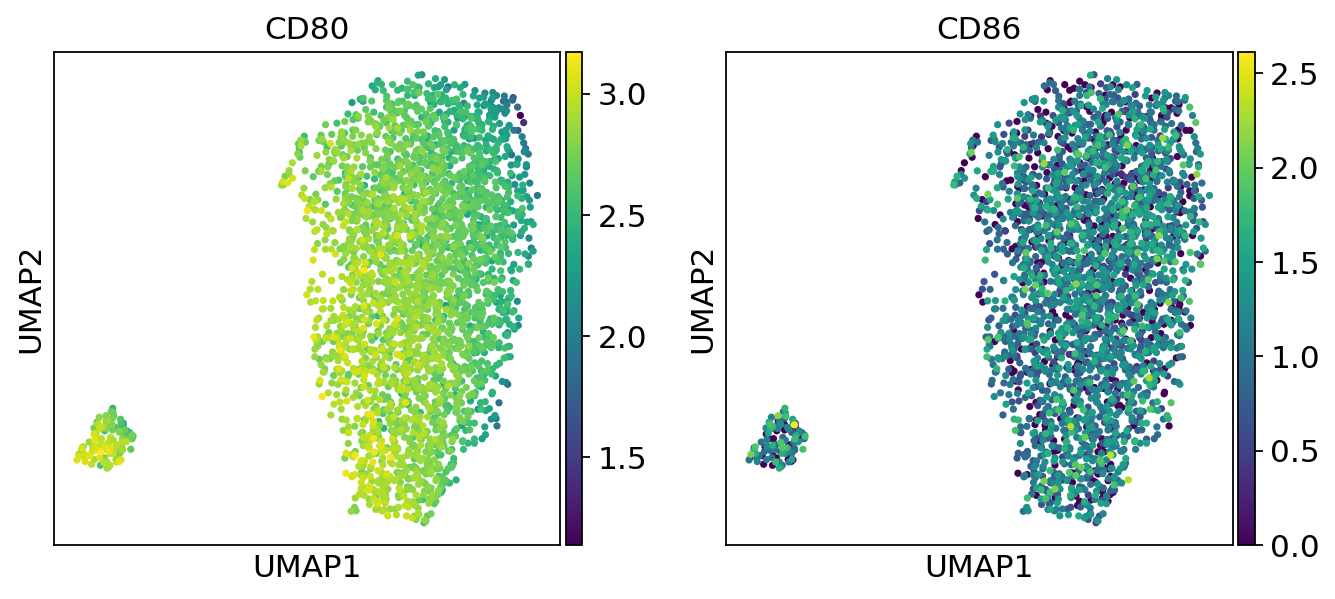

In [17]:
sc.pp.neighbors(adata_true_proteins_common)
sc.tl.umap(adata_true_proteins_common)
sc.pl.umap(
    adata_true_proteins_common,
    color = ["CD80","CD86"]
)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:50)


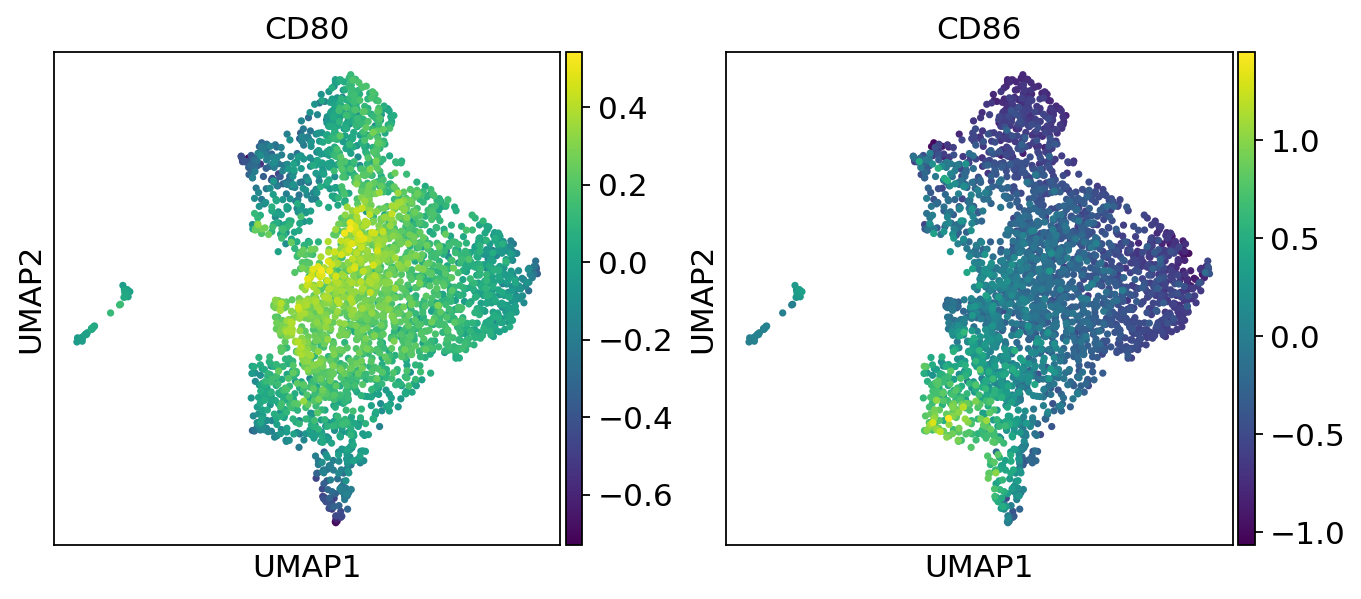

In [18]:
sc.pp.neighbors(adata_imputed_proteins_common)
sc.tl.umap(adata_imputed_proteins_common)
sc.pl.umap(
    adata_imputed_proteins_common,
    color = ["CD80","CD86"]
)

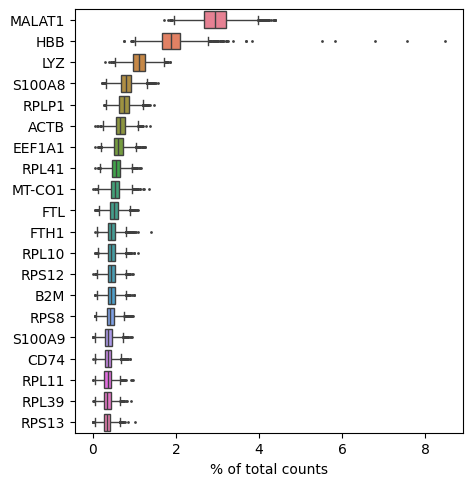

In [29]:
sc.pl.highest_expr_genes(adata_GSM5319_RNA, n_top=20)

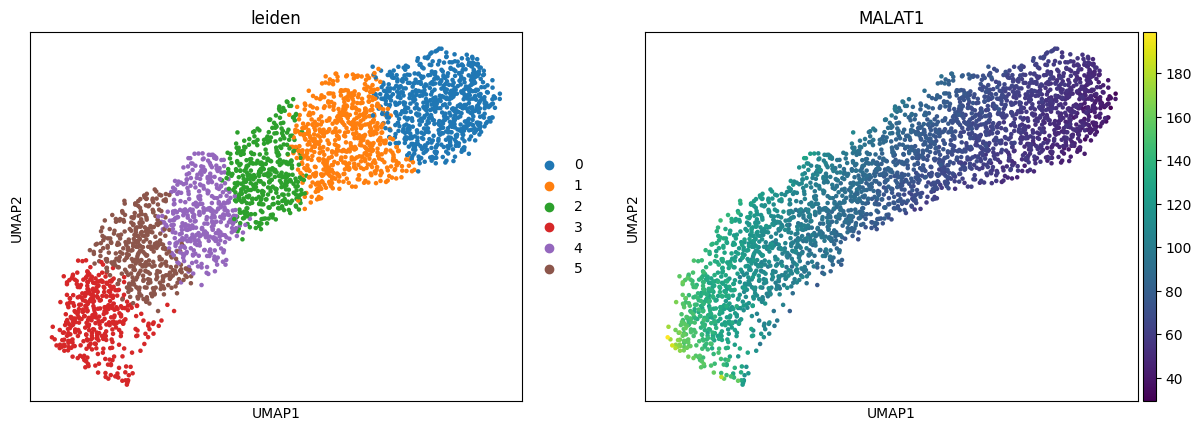

In [30]:
sc.pp.neighbors(adata_GSM5319_RNA)
resolution = 1.0
sc.tl.leiden(adata_GSM5319_RNA,resolution = resolution)
sc.tl.paga(adata_GSM5319_RNA)
sc.pl.paga(adata_GSM5319_RNA, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_GSM5319_RNA, init_pos='paga')
sc.pl.umap(adata_GSM5319_RNA, color=["leiden","MALAT1"])

computing neighbors
computing PCA
    with n_comps=50


/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 138 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
running Leiden clustering


/tmp/ipykernel_118659/3539522665.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_GSM5320_ADT,resolution = resolution)


    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


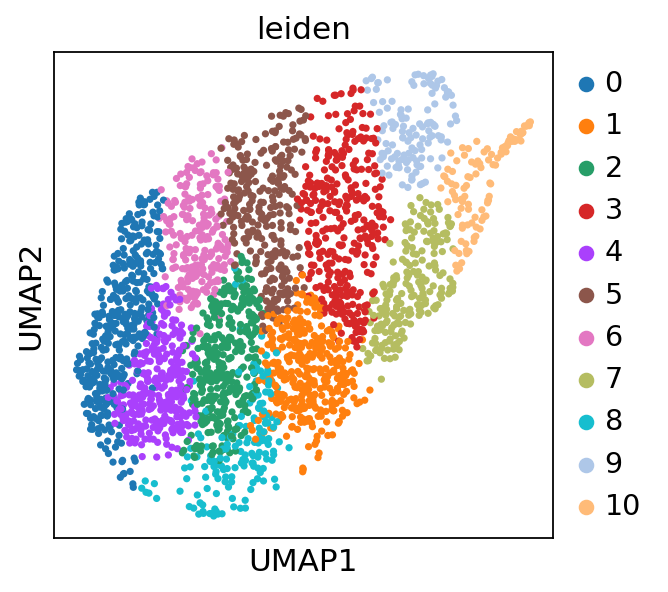

In [18]:
sc.pp.neighbors(adata_GSM5320_ADT)
resolution = 1.0
sc.tl.leiden(adata_GSM5320_ADT,resolution = resolution)
sc.tl.paga(adata_GSM5320_ADT)
sc.pl.paga(adata_GSM5320_ADT, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_GSM5320_ADT, init_pos='paga')
sc.pl.umap(adata_GSM5320_ADT, color=["leiden"])

computing neighbors
computing PCA
    with n_comps=50


/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 102 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


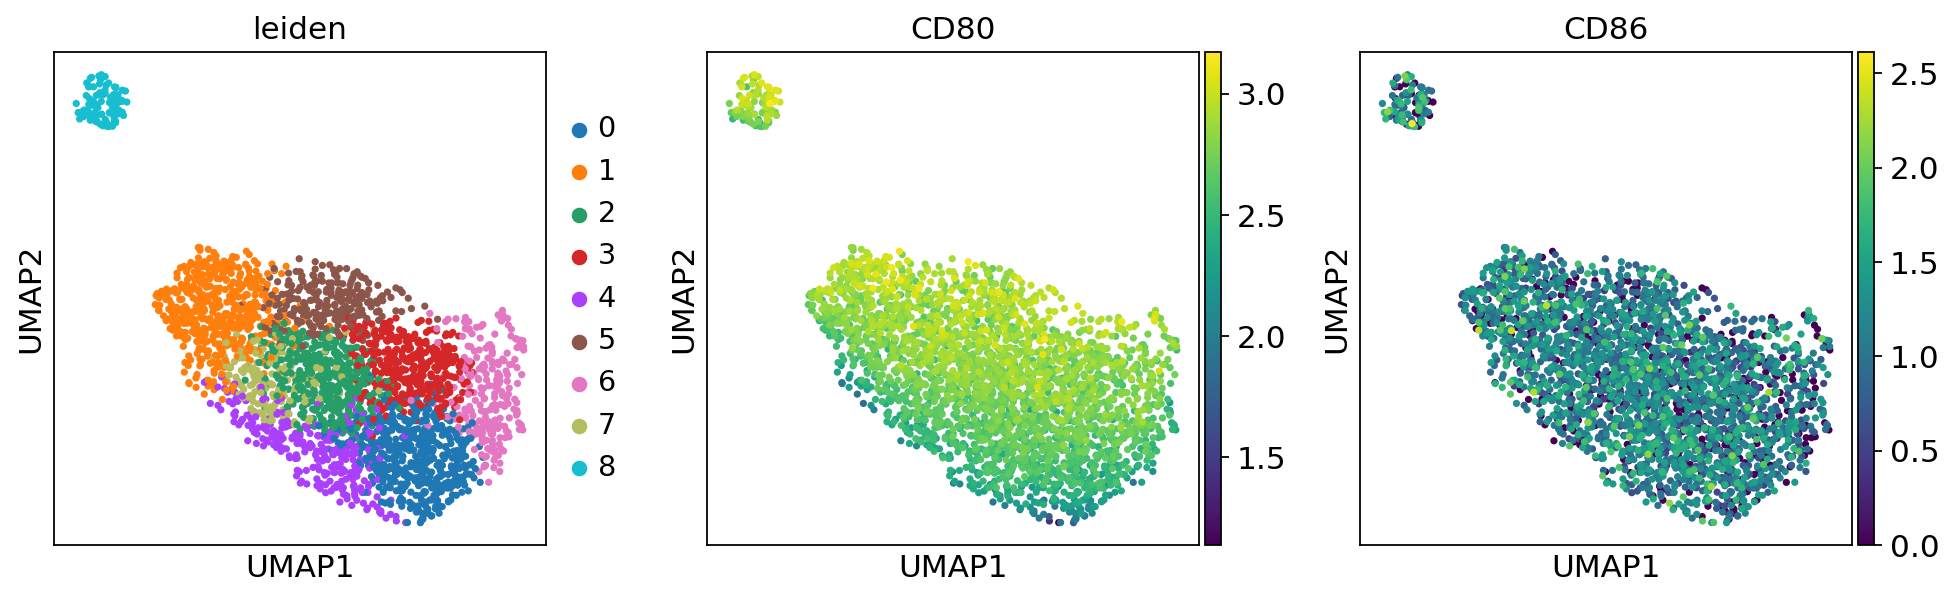

In [19]:
sc.pp.neighbors(adata_true_proteins_common)
resolution = 1.0
sc.tl.leiden(adata_true_proteins_common,resolution = resolution)
sc.tl.paga(adata_true_proteins_common)
sc.pl.paga(adata_true_proteins_common, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_true_proteins_common, init_pos='paga')
sc.pl.umap(adata_true_proteins_common, color=["leiden", "CD80", "CD86"])

computing neighbors
computing PCA
    with n_comps=50


/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 102 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


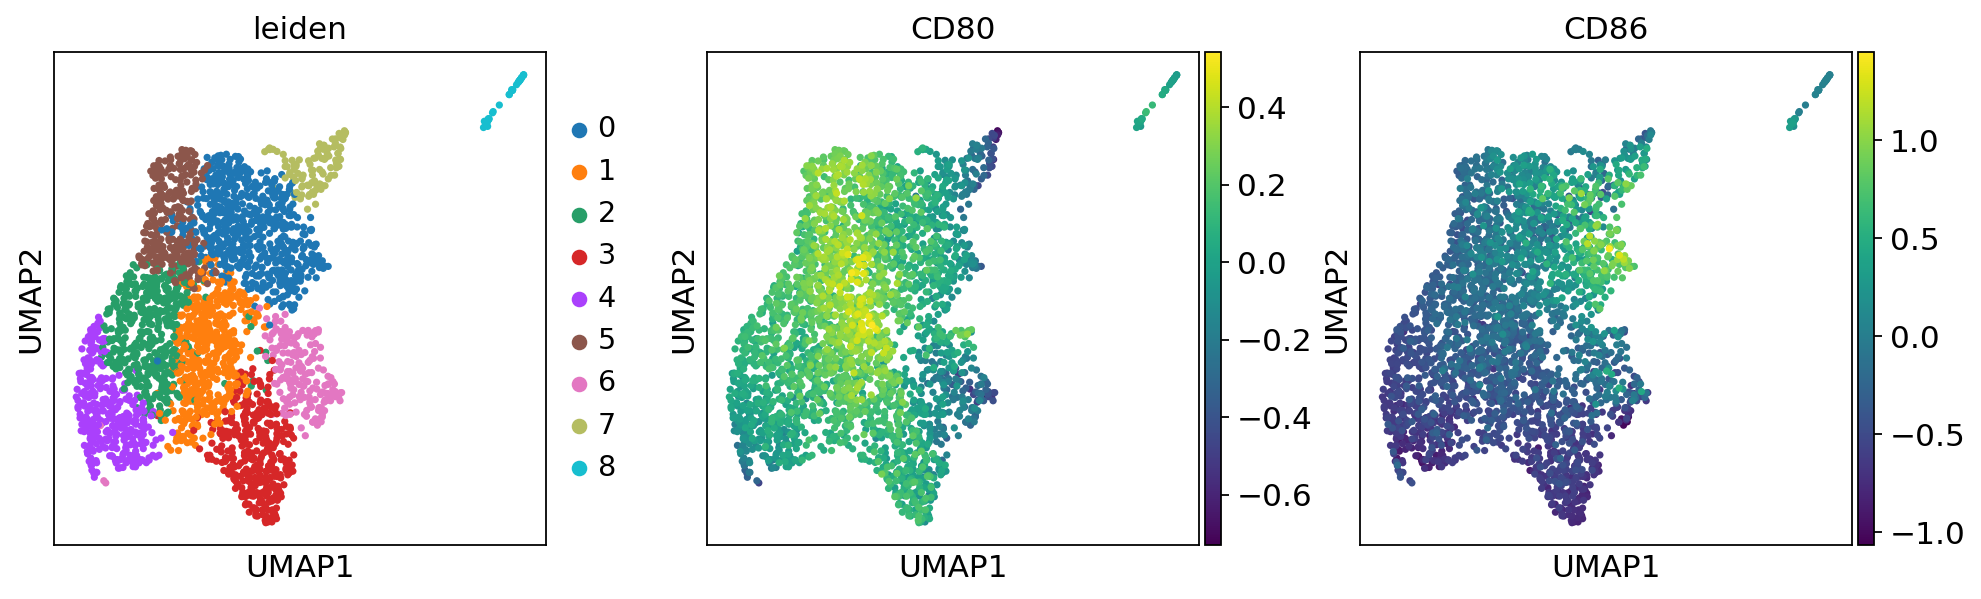

In [20]:
sc.pp.neighbors(adata_imputed_proteins_common)
resolution = 0.5
sc.tl.leiden(adata_imputed_proteins_common,resolution = resolution)
sc.tl.paga(adata_imputed_proteins_common)
sc.pl.paga(adata_imputed_proteins_common, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_imputed_proteins_common, init_pos='paga')
sc.pl.umap(adata_imputed_proteins_common, color=["leiden", "CD80", "CD86"])

In [21]:
adata_imputed_proteins_common

AnnData object with n_obs × n_vars = 2826 × 102
    obs: 'batch', 'scale_factor', 'transfered cell labels', 'leiden'
    uns: 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
adata_imputed_proteins_common.obs

,batch,scale_factor,transfered cell labels,leiden
AAACCTGAGCAGCGTA-1,DS-Test,1815.0,gdT,1
AAACCTGGTCTTGCGG-1,DS-Test,4354.0,CD4 TCM,3
AAACCTGGTTCGCTAA-1,DS-Test,2329.0,B naive,8
AAACCTGTCGACAGCC-1,DS-Test,1743.0,CD4 Naive,1
AAACGGGAGGCATTGG-1,DS-Test,3141.0,NK,0
...,...,...,...,...
TTTGTCAAGCTGTCTA-1,DS-Test,4697.0,cDC2,0
TTTGTCACAAGTTCTG-1,DS-Test,4106.0,B naive,8
TTTGTCAGTTTGGGCC-1,DS-Test,1819.0,CD4 TCM,3
TTTGTCATCCAATGGT-1,DS-Test,2886.0,Platelet,0


In [48]:
test_imputed = adata_imputed_proteins_common.to_df().sample(n=500,random_state=42)

np.random.seed(42)
selected_indices = np.random.choice(adata_true_proteins_common.n_obs, 500, replace=False)
test_true = adata_true_proteins_common[selected_indices, :]

In [53]:
obs_names = test_true.obs_names

# Get index names from the pandas DataFrame
index_names = test_imputed.index

# Check if they match perfectly
if obs_names.equals(index_names):
    print("The obs_names of AnnData and index of DataFrame match perfectly.")
else:
    print("Mismatch found between obs_names of AnnData and index of DataFrame.")

The obs_names of AnnData and index of DataFrame match perfectly.


FeedForward Network to Train Model on ADT clustering

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import mlflow

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Convert numpy array to tensor
        data = torch.from_numpy(self.data[idx]).float()
        label = torch.tensor(self.labels[idx]).long()
        return data, label

class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage:
input_size = adata_imputed_proteins_common.X.shape[1]  # Get input size from data
hidden_size = 256
output_size = len(np.unique(adata_true_proteins_common.obs['leiden']))

# Create dataset
data = adata_imputed_proteins_common.X
labels = adata_true_proteins_common.obs['leiden'].values

# Convert labels to numeric format if they're not already
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
numeric_labels = np.array([label_to_index[label] for label in labels])

dataset = CustomDataset(data, numeric_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model, loss, and optimizer
model = FeedForwardNet(input_size, hidden_size, output_size)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(10):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        # Move data and labels to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/20], Average Loss: {avg_loss:.4f}')

    # Save the model
torch.save(model.state_dict(), 'feedforward_model.pth')
print("Model saved successfully!")

# To save additional information (optional)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, 'feedforward_model_checkpoint.pth')
print("Model checkpoint saved successfully!")

Epoch [1/20], Average Loss: 2.1262
Epoch [2/20], Average Loss: 2.0922
Epoch [3/20], Average Loss: 2.0880
Epoch [4/20], Average Loss: 2.0767
Epoch [5/20], Average Loss: 2.0766
Epoch [6/20], Average Loss: 2.0683
Epoch [7/20], Average Loss: 2.0642
Epoch [8/20], Average Loss: 2.0571
Epoch [9/20], Average Loss: 2.0556
Epoch [10/20], Average Loss: 2.0494
Model saved successfully!
Model checkpoint saved successfully!


Predictions

In [25]:
# Load the checkpoint
checkpoint = torch.load('feedforward_model_checkpoint.pth')

# Initialize the model
model = FeedForwardNet(input_size, hidden_size, output_size)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# If you want to resume training, you can also load the optimizer state
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(f"Model checkpoint loaded successfully! Epoch: {epoch}, Loss: {loss:.4f}")

# Set the model to evaluation mode if you're doing inference
model.eval()

# Or set it to training mode if you're resuming training
# model.train()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model checkpoint loaded successfully! Epoch: 9, Loss: 2.0494


/tmp/ipykernel_118659/2193246447.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('feedforward_model_checkpoint.pth')


FeedForwardNet(
  (fc1): Linear(in_features=102, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)

In [49]:

import torch

# Assuming you have some new data to predict on
new_data = torch.tensor(test_imputed.values).float().to(device)

with torch.no_grad():
    outputs = model(new_data)
    _, predicted = torch.max(outputs, 1)

print("Predictions:", predicted)

Predictions: tensor([0, 1, 0, 1, 0, 2, 0, 0, 3, 1, 1, 1, 0, 0, 2, 1, 0, 0, 3, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 1, 3, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0,
        1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 0, 0, 3, 0, 2, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0,
        0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 3, 0, 0, 1, 1, 0, 2, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 3, 1, 1, 0, 1, 0, 1, 2,
        0, 0, 1, 0, 1, 2, 3, 0, 1, 1, 0, 1, 0, 0, 2, 1, 3, 0, 1, 0, 0, 0, 2, 2,
        3, 1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 3, 3, 2, 1, 2, 1, 0,
        0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 3, 0, 1, 1, 0, 0, 2, 0,
        0, 3, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 3, 1, 1, 2, 1, 1, 2, 1, 2,
        2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 0,
        2, 3, 0, 0, 2, 5, 1

/home/nandivada.s/.conda/envs/scipennenv/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:449: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


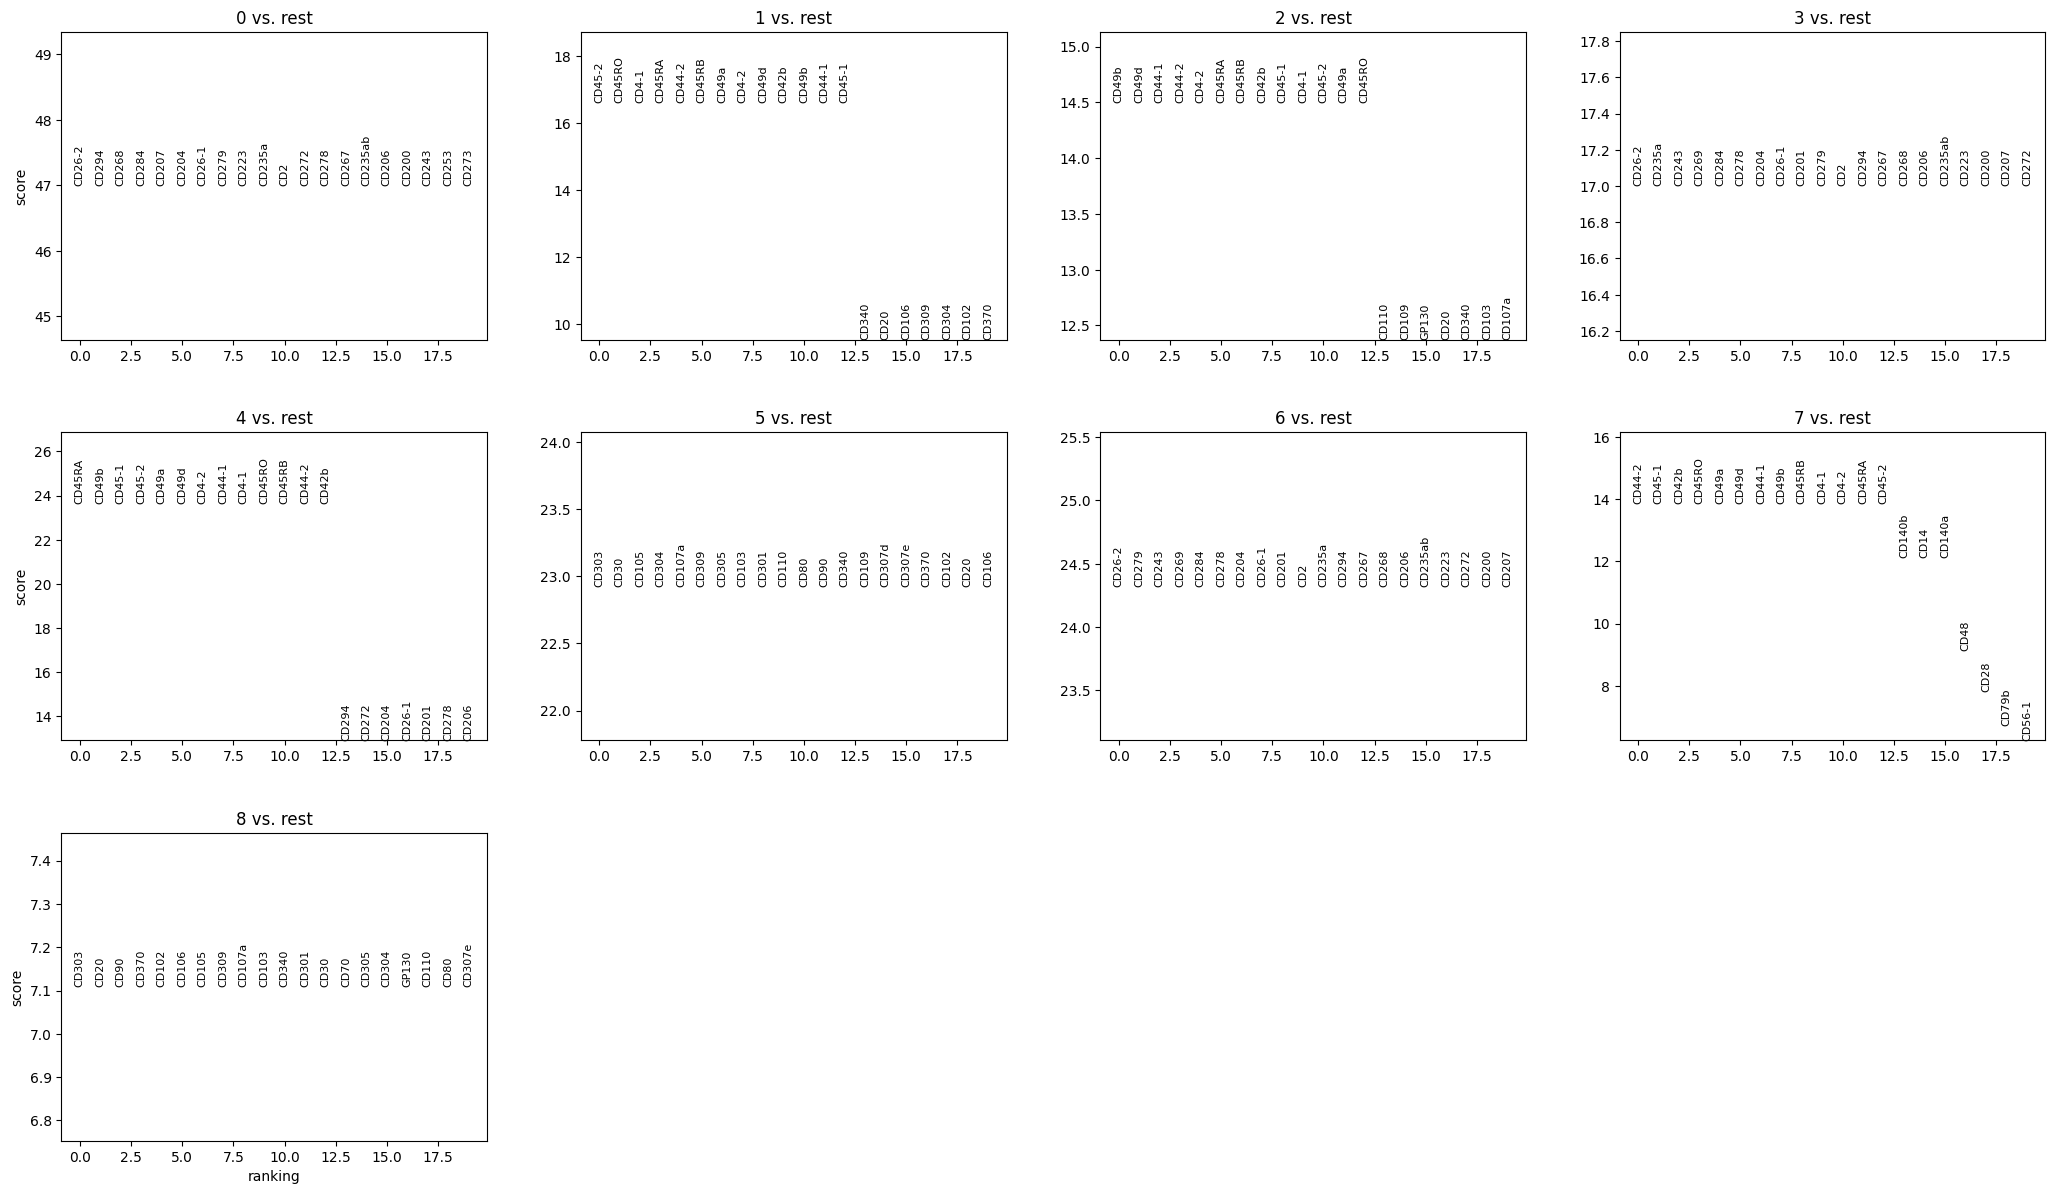

In [14]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata_true_proteins_common, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_true_proteins_common, n_genes=20, sharey=False)


In [18]:
result = adata_true_proteins_common.uns['rank_genes_groups']

# Get the names of the clusters
groups = result['names'].dtype.names

# Create a dictionary to store highly expressed genes for each cluster
highly_expressed_genes = {group: result['names'][group] for group in groups}

# Convert the results to a DataFrame for better visualization
df_genes = pd.DataFrame(highly_expressed_genes)

df_genes



,0,1,2,3,4,5,6,7,8
0,CD26-2,CD45-2,CD49b,CD26-2,CD45RA,CD303,CD26-2,CD44-2,CD303
1,CD294,CD45RO,CD49d,CD235a,CD49b,CD30,CD279,CD45-1,CD20
2,CD268,CD4-1,CD44-1,CD243,CD45-1,CD105,CD243,CD42b,CD90
3,CD284,CD45RA,CD44-2,CD269,CD45-2,CD304,CD269,CD45RO,CD370
4,CD207,CD44-2,CD4-2,CD284,CD49a,CD107a,CD284,CD49a,CD102
...,...,...,...,...,...,...,...,...,...
97,CD303,CD235ab,CD38-1,CD49b,CD102,CD235ab,CD49b,CD235ab,CD235ab
98,CD107a,CD278,CD38-2,CD44-2,CD370,CD278,CD44-2,CD278,CD278
99,CD309,CD272,CD140b,CD42b,CD340,CD272,CD42b,CD272,CD272
100,CD106,CD223,CD140a,CD45RB,CD103,CD223,CD45RB,CD223,CD223


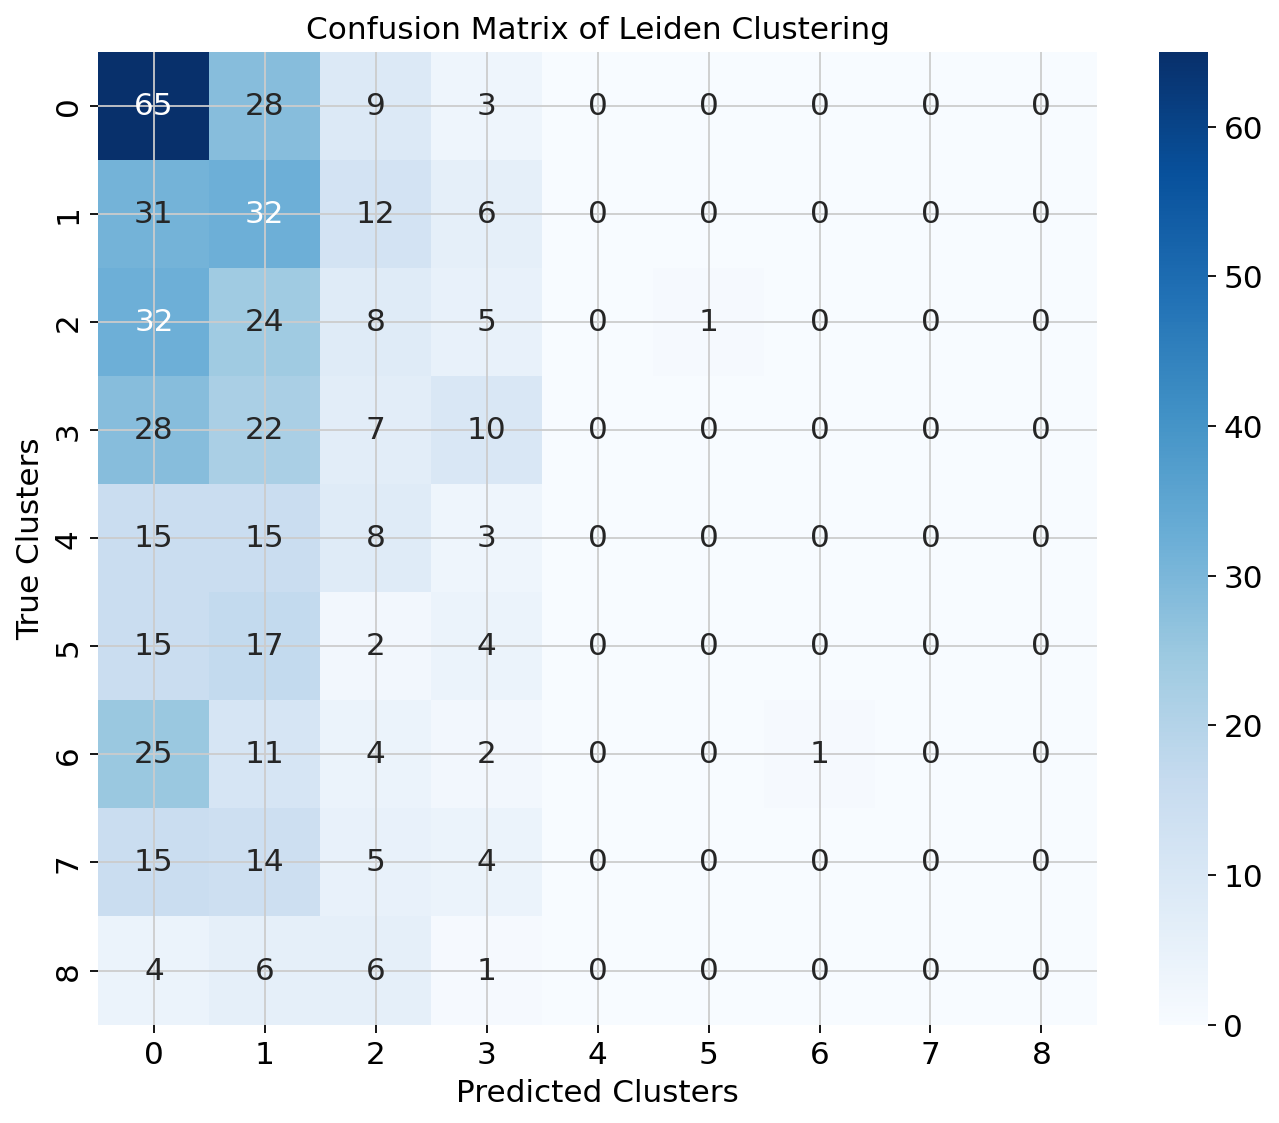

In [50]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Ensure that both AnnData objects have the Leiden clustering labels
true_labels = test_true.obs['leiden'].to_numpy().astype(int)
predicted_labels = predicted.cpu().numpy()



# Optionally, you can visualize the clustering agreement using a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Clusters')
plt.ylabel('True Clusters')
plt.title('Confusion Matrix of Leiden Clustering')
plt.show()


In [47]:
true_labels

array(['1', '3', '2', '0', '1', '2', '6', '1', '1', '0', '1', '0', '4',
       '3', '3', '2', '5', '2', '0', '8', '4', '2', '8', '0', '3', '2',
       '1', '0', '8', '4', '0', '3', '0', '3', '5', '5', '4', '1', '3',
       '1', '6', '6', '4', '6', '2', '2', '0', '0', '0', '2', '0', '4',
       '4', '0', '3', '6', '0', '1', '4', '6', '5', '4', '7', '5', '6',
       '3', '2', '3', '3', '0', '2', '0', '4', '2', '4', '0', '1', '2',
       '1', '3', '0', '2', '4', '0', '6', '6', '0', '2', '2', '2', '3',
       '3', '0', '1', '7', '3', '2', '5', '4', '6', '2', '8', '7', '0',
       '1', '3', '1', '5', '5', '4', '0', '8', '7', '2', '1', '3', '2',
       '3', '4', '2', '3', '7', '8', '0', '0', '5', '3', '3', '0', '6',
       '5', '6', '2', '5', '7', '1', '0', '6', '1', '1', '4', '5', '4',
       '2', '0', '2', '0', '1', '3', '1', '7', '1', '3', '4', '0', '6',
       '3', '7', '1', '6', '0', '3', '4', '6', '2', '0', '0', '3', '4',
       '4', '5', '0', '2', '8', '3', '2', '0', '4', '5', '7', '5